In [ ]:
#import requirements
!pip install transformers
from transformers import CLIPProcessor, CLIPModel
import torch
import numpy as np
import os

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 91.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 107.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 62.1 MB/s eta 0:00:00


In [ ]:
# create the labels
my_label = ('daisy','dandelion','rose','sunflower','tulip')
clip_labels = [f"a photo of a {label}" for label in my_label]
clip_labels

['a photo of a daisy',
 'a photo of a dandelion',
 'a photo of a rose',
 'a photo of a sunflower',
 'a photo of a tulip']

In [ ]:
# initialization of the model

model_id = "openai/clip-vit-base-patch32"

processor = CLIPProcessor.from_pretrained(model_id)
model = CLIPModel.from_pretrained(model_id)

In [ ]:
# if you have CUDA set it to the active device like this
device = "cuda" if torch.cuda.is_available() else "cpu"
# move the model to the device
model.to(device)

device

'cpu'

In [ ]:
# create label tokens
label_tokens = processor(
    text=clip_labels,
    padding=True,
    images=None,
    return_tensors='pt'
).to(device)

label_tokens['input_ids'][0][:10]

tensor([49406,   320,  1125,   539,   320, 12865, 49407])

In [ ]:
# encode tokens to sentence embeddings
label_emb = model.get_text_features(**label_tokens)

# detach from pytorch gradient computation
label_emb = label_emb.detach().cpu().numpy()
label_emb.shape

(5, 512)

In [ ]:
label_emb.min(), label_emb.max()

(-1.2760261, 5.3769913)

In [ ]:
# normalization
label_emb = label_emb / np.linalg.norm(label_emb, axis=0)
label_emb.min(), label_emb.max()

(-0.98502344, 0.9620458)

In [ ]:
import os
path = "/content/drive/MyDrive/5_Flower/jpg";
for dir in os.listdir(path):
  print(dir)

daisy
dandelion
rose
sunflower
tulip


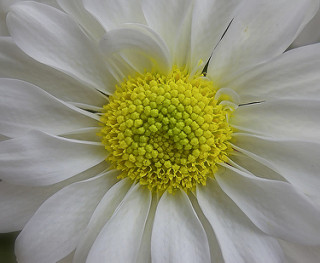

In [ ]:
#open image
path_to_image = "/content/drive/MyDrive/5_Flower/jpg/daisy/100080576_f52e8ee070_n.jpg";
from PIL import Image
img = Image.open(path_to_image)
img

In [ ]:
# encode the image
image = processor(
    text=None,
    images=img,
    return_tensors='pt'
)['pixel_values'].to(device)
image.shape

torch.Size([1, 3, 224, 224])

In [ ]:
img_emb = model.get_image_features(image)
img_emb.shape

torch.Size([1, 512])

In [ ]:
img_emb = img_emb.detach().cpu().numpy()

In [ ]:
scores = np.dot(img_emb, label_emb.T)
scores.shape

(1, 5)

In [ ]:
# get index of highest score
pred = np.argmax(scores)
print("predicted = ",pred)

#for actual answer
# temp = path_to_image.split("_")[2].split(".");
# print("Actual = ", int(int(temp[0])/80))

predicted =  0


In [ ]:
# find text label with highest score
my_label[pred]

'daisy'

In [ ]:
# test all the images
path = '/content/drive/MyDrive/5_Flower/jpg'
preds = []
batch_size = 32

for dir in os.listdir(path):
  for files in os.listdir(path+'/'+dir):
    file_name = path+'/'+dir+'/'+files
    img = Image.open(file_name)
    images = processor(
        text=None,
        images=img,
        return_tensors='pt'
    )['pixel_values'].to(device)
    img_emb = model.get_image_features(images)
    img_emb = img_emb.detach().cpu().numpy()
    scores = np.dot(img_emb, label_emb.T)
    preds.extend(np.argmax(scores, axis=1))

In [ ]:
# accuracy
true_preds = []
sample = [764, 1052, 784, 733, 1001]
final = [0]*sample[0] + [1]*sample[1] + [2]*sample[2] + [3]*sample[3] + [4]*sample[4]

for i,ele in enumerate(preds):
    if final[i] == ele:
        true_preds.append(1)
    else:
        true_preds.append(0)

(sum(true_preds) / len(true_preds))*100

94.04706968158744

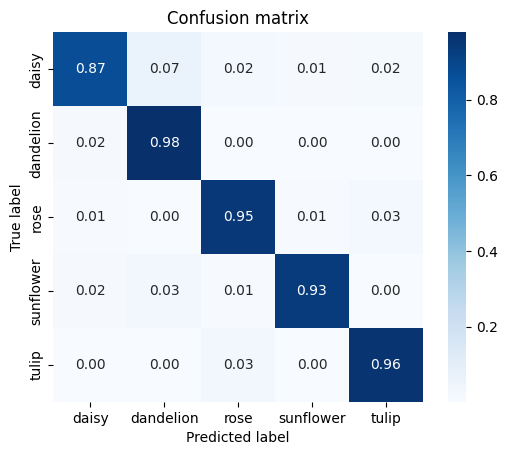

In [ ]:
# print confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.metrics as sk_metrics

c = sk_metrics.confusion_matrix(preds,final)
confusion_normalized = c.astype("float") / c.sum(axis=1)
sns.heatmap(confusion_normalized,
            xticklabels=my_label,
            yticklabels=my_label,
            cmap='Blues',
            annot=True,
            fmt='.2f',
            square=True)

plt.title("Confusion matrix")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()